# Detection with only the basic image operation (filter, Mophology, ...)

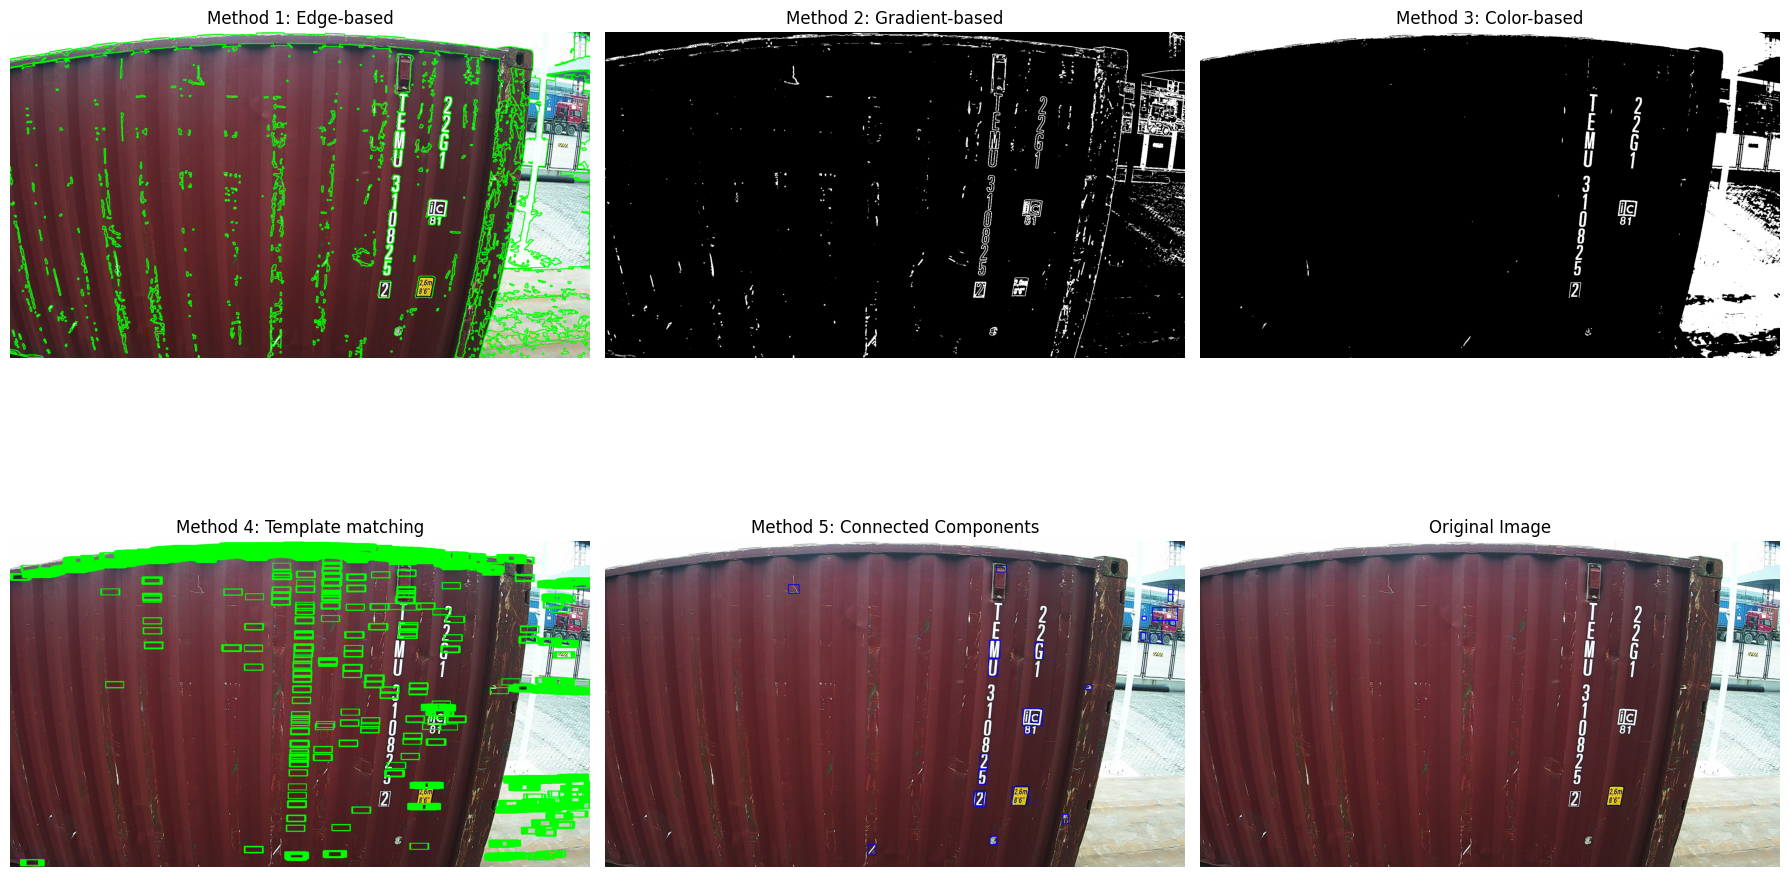

In [91]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

class AlternativeDetectionMethods:
    
    def method_1_edge_based(self, image):
        """Edge-based text detection using Canny and morphology"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Canny edge detection
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        
        # Dilate edges to connect text components
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilated = cv2.dilate(edges, kernel, iterations=1)
        
        # Find contours
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        return contours, dilated
    
    def method_2_gradient_based(self, image):
        """Gradient-based approach using Sobel operators"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Calculate gradients
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate gradient magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        magnitude = np.uint8(magnitude / magnitude.max() * 255)
        
        # Threshold to get binary image
        _, binary = cv2.threshold(magnitude, 50, 255, cv2.THRESH_BINARY)
        
        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
        return processed
    
    def method_3_color_based(self, image):
        """Color-based segmentation for white text on red background"""
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Define range for white/light colors (text)
        lower_white = np.array([0, 0, 180])
        upper_white = np.array([180, 30, 255])
        
        # Create mask for white regions
        white_mask = cv2.inRange(hsv, lower_white, upper_white)
        
        # Clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel)
        
        return cleaned
    
    def method_4_template_matching(self, image):
        """Template-based approach for specific patterns"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Create simple templates for digit and letter patterns
        # This is a basic approach - you'd need actual templates for better results
        
        # Template for rectangular text regions
        template_rect = np.ones((20, 60), dtype=np.uint8) * 255
        template_rect[5:15, 5:55] = 0  # Create a border pattern
        
        # Match template
        result = cv2.matchTemplate(gray, template_rect, cv2.TM_CCOEFF_NORMED)
        locations = np.where(result >= 0.3)
        
        return locations, result
    
    def method_5_connected_components(self, image):
        """Connected components analysis"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Threshold
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Connected components analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
        
        # Filter components based on size and aspect ratio
        text_components = []
        for i in range(1, num_labels):  # Skip background (label 0)
            x, y, w, h, area = stats[i]
            aspect_ratio = w / h if h > 0 else 0
            
            # Filter based on text-like properties
            if (100 < area < 2000 and 
                0.5 < aspect_ratio < 5 and 
                w > 10 and h > 8):
                text_components.append((x, y, w, h, area))
        
        return text_components, labels
    
    def compare_methods(self, image_path):
        """Compare all detection methods"""
        image = cv2.imread(image_path)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Method 1: Edge-based
        contours1, edges = self.method_1_edge_based(image)
        result1 = image.copy()
        cv2.drawContours(result1, contours1, -1, (0, 255, 0), 2)
        axes[0, 0].imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Method 1: Edge-based')
        axes[0, 0].axis('off')
        
        # Method 2: Gradient-based
        gradient_result = self.method_2_gradient_based(image)
        axes[0, 1].imshow(gradient_result, cmap='gray')
        axes[0, 1].set_title('Method 2: Gradient-based')
        axes[0, 1].axis('off')
        
        # Method 3: Color-based
        color_result = self.method_3_color_based(image)
        axes[0, 2].imshow(color_result, cmap='gray')
        axes[0, 2].set_title('Method 3: Color-based')
        axes[0, 2].axis('off')
        
        # Method 4: Template matching
        locations, template_result = self.method_4_template_matching(image)
        result4 = image.copy()
        for pt in zip(*locations[::-1]):
            cv2.rectangle(result4, pt, (pt[0] + 60, pt[1] + 20), (0, 255, 0), 2)
        axes[1, 0].imshow(cv2.cvtColor(result4, cv2.COLOR_BGR2RGB))
        axes[1, 0].set_title('Method 4: Template matching')
        axes[1, 0].axis('off')
        
        # Method 5: Connected components
        components, labels = self.method_5_connected_components(image)
        result5 = image.copy()
        for x, y, w, h, area in components:
            cv2.rectangle(result5, (x, y), (x+w, y+h), (255, 0, 0), 2)
        axes[1, 1].imshow(cv2.cvtColor(result5, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title('Method 5: Connected Components')
        axes[1, 1].axis('off')
        
        # Original image
        axes[1, 2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[1, 2].set_title('Original Image')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()

# Usage example
def test_alternative_methods():
    detector = AlternativeDetectionMethods()
    
    # Replace with your image path
    image_path = r"images\1-122700001-OCR-LF-C01.jpg"
    
    try:
        detector.compare_methods(image_path)
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    test_alternative_methods()

Running hybrid detection...


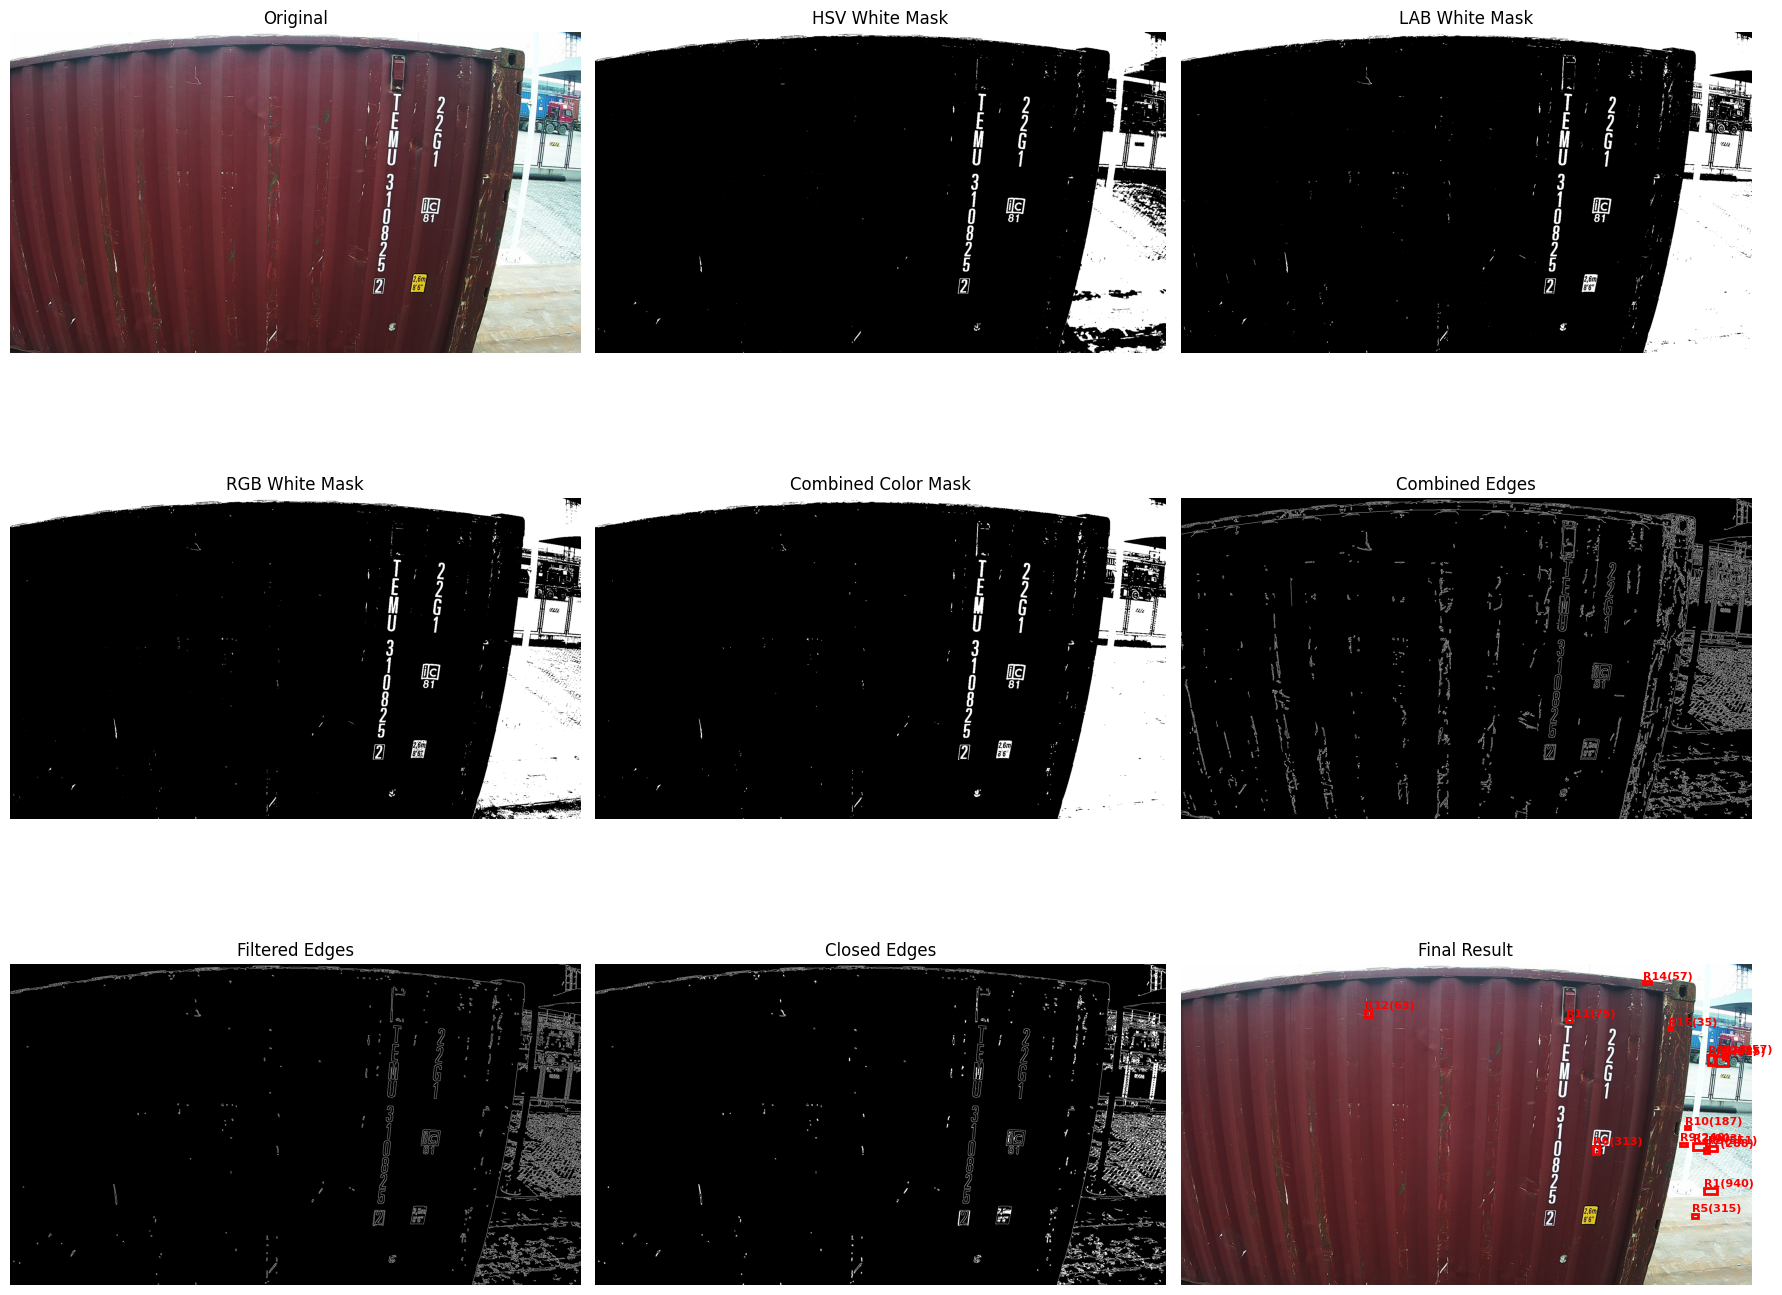

Detected 15 container code regions:
--------------------------------------------------------------------------------
Region 1:
  Position: (1760, 752)
  Size: 47 x 20
  Area: 940
  Aspect Ratio: 2.35
  White Density: 1.00
  Solidity: 0.10
  Score: 940

Region 2:
  Position: (1726, 603)
  Size: 43 x 21
  Area: 903
  Aspect Ratio: 2.05
  White Density: 1.00
  Solidity: 0.17
  Score: 903

Region 3:
  Position: (1775, 610)
  Size: 29 x 19
  Area: 551
  Aspect Ratio: 1.53
  White Density: 1.00
  Solidity: 0.16
  Score: 551

Region 4:
  Position: (1803, 309)
  Size: 40 x 33
  Area: 1320
  Aspect Ratio: 1.21
  White Density: 0.29
  Solidity: 0.46
  Score: 385

Region 5:
  Position: (1720, 839)
  Size: 21 x 15
  Area: 315
  Aspect Ratio: 1.40
  White Density: 1.00
  Solidity: 0.18
  Score: 315

Region 6:
  Position: (1389, 612)
  Size: 20 x 28
  Area: 560
  Aspect Ratio: 0.71
  White Density: 0.56
  Solidity: 0.74
  Score: 313

Region 7:
  Position: (1762, 618)
  Size: 18 x 16
  Area: 288
  As

In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class HybridContainerCodeDetector:
    def __init__(self):
        self.debug_images = {}
    
    def enhanced_color_segmentation(self, image):
        """Improved color-based segmentation with multiple color spaces"""
        # Method 1: HSV-based white detection
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_white = np.array([0, 0, 180])
        upper_white = np.array([180, 30, 255])
        white_mask_hsv = cv2.inRange(hsv, lower_white, upper_white)
        
        # Method 2: LAB-based approach (better for lighting variations)
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel = lab[:, :, 0]
        # High L values indicate bright/white regions
        _, white_mask_lab = cv2.threshold(l_channel, 160, 255, cv2.THRESH_BINARY)
        
        # Method 3: RGB-based approach
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, white_mask_rgb = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
        
        # Combine all masks
        combined_mask = cv2.bitwise_or(white_mask_hsv, white_mask_lab)
        combined_mask = cv2.bitwise_or(combined_mask, white_mask_rgb)
        
        # Clean up the mask
        kernel_clean = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel_clean)
        
        # Connect nearby text characters
        kernel_connect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        final_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_connect)
        
        self.debug_images['white_mask_hsv'] = white_mask_hsv
        self.debug_images['white_mask_lab'] = white_mask_lab
        self.debug_images['white_mask_rgb'] = white_mask_rgb
        self.debug_images['combined_color_mask'] = final_mask
        
        return final_mask
    
    def smart_edge_detection(self, image, color_mask=None):
        """Edge detection with region-based filtering"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # Multi-scale edge detection
        edges1 = cv2.Canny(blurred, 30, 100)
        edges2 = cv2.Canny(blurred, 50, 150)
        edges3 = cv2.Canny(blurred, 70, 200)
        
        # Combine edges
        combined_edges = cv2.bitwise_or(edges1, edges2)
        combined_edges = cv2.bitwise_or(combined_edges, edges3)
        
        # If we have a color mask, use it to filter edges
        if color_mask is not None:
            # Only keep edges that are near white regions
            kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
            dilated_mask = cv2.dilate(color_mask, kernel_dilate, iterations=1)
            filtered_edges = cv2.bitwise_and(combined_edges, dilated_mask)
        else:
            filtered_edges = combined_edges
        
        # Morphological operations to connect text components
        kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
        closed_edges = cv2.morphologyEx(filtered_edges, cv2.MORPH_CLOSE, kernel_close)
        
        self.debug_images['combined_edges'] = combined_edges
        self.debug_images['filtered_edges'] = filtered_edges
        self.debug_images['closed_edges'] = closed_edges
        
        return closed_edges
    
    def intelligent_region_filtering(self, contours, image_shape, color_mask=None):
        """Advanced filtering based on multiple criteria"""
        height, width = image_shape[:2]
        filtered_regions = []
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            aspect_ratio = w / h if h > 0 else 0
            
            # Basic size and aspect ratio filtering
            if not (50 < area < 3000 and 0.3 < aspect_ratio < 8):
                continue
            
            # Position filtering - container codes are typically in specific areas
            # Right side of container, upper portion
            if not (x > width * 0.3 and y < height * 0.8):
                continue
            
            # Dimension filtering for text-like regions
            if not (15 < w < 150 and 8 < h < 40):
                continue
            
            # If we have a color mask, check white pixel density
            white_density = 0
            if color_mask is not None:
                roi_mask = color_mask[y:y+h, x:x+w]
                white_pixels = np.sum(roi_mask == 255)
                total_pixels = w * h
                white_density = white_pixels / total_pixels if total_pixels > 0 else 0
                
                # Filter regions with insufficient white content
                if white_density < 0.1:
                    continue
            
            # Calculate solidity (contour area vs bounding rectangle area)
            contour_area = cv2.contourArea(contour)
            solidity = contour_area / area if area > 0 else 0
            
            # Text regions should have reasonable solidity
            if solidity < 0.1 or solidity > 0.9:
                continue
            
            filtered_regions.append({
                'contour': contour,
                'bbox': (x, y, w, h),
                'area': area,
                'aspect_ratio': aspect_ratio,
                'white_density': white_density,
                'solidity': solidity
            })
        
        # Sort by combination of area and white density
        filtered_regions.sort(key=lambda x: (x['area'] * x['white_density']), reverse=True)
        
        return filtered_regions
    
    def detect_container_codes(self, image_path):
        """Main hybrid detection function"""
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        self.debug_images['original'] = image
        
        # Step 1: Color-based segmentation to find white text
        color_mask = self.enhanced_color_segmentation(image)
        
        # Step 2: Smart edge detection using color information
        edge_image = self.smart_edge_detection(image, color_mask)
        
        # Step 3: Find contours from edge image
        contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Step 4: Intelligent filtering
        code_regions = self.intelligent_region_filtering(contours, image.shape, color_mask)
        
        # Step 5: Extract ROI images
        for i, region in enumerate(code_regions):
            x, y, w, h = region['bbox']
            region['roi_original'] = image[y:y+h, x:x+w]
            region['roi_mask'] = color_mask[y:y+h, x:x+w]
        
        return code_regions
    
    def non_maximum_suppression(self, regions, overlap_threshold=0.3):
        """Remove overlapping detections"""
        if len(regions) == 0:
            return []
        
        # Sort by score (area * white_density)
        regions = sorted(regions, key=lambda x: x['area'] * x['white_density'], reverse=True)
        
        keep = []
        while len(regions) > 0:
            current = regions.pop(0)
            keep.append(current)
            
            # Remove overlapping regions
            regions = [r for r in regions if self.calculate_overlap(current['bbox'], r['bbox']) < overlap_threshold]
        
        return keep
    
    def calculate_overlap(self, bbox1, bbox2):
        """Calculate overlap ratio between two bounding boxes"""
        x1, y1, w1, h1 = bbox1
        x2, y2, w2, h2 = bbox2
        
        # Calculate intersection
        x_left = max(x1, x2)
        y_top = max(y1, y2)
        x_right = min(x1 + w1, x2 + w2)
        y_bottom = min(y1 + h1, y2 + h2)
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection = (x_right - x_left) * (y_bottom - y_top)
        area1 = w1 * h1
        area2 = w2 * h2
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0.0
    
    def visualize_results(self, image_path, show_debug=True):
        """Comprehensive visualization"""
        image = cv2.imread(image_path)
        code_regions = self.detect_container_codes(image_path)
        
        # Apply non-maximum suppression
        code_regions = self.non_maximum_suppression(code_regions)
        
        if show_debug:
            # Create visualization
            fig, axes = plt.subplots(3, 3, figsize=(18, 15))
            axes = axes.flatten()
            
            # Show processing steps
            steps = [
                ('Original', 'original'),
                ('HSV White Mask', 'white_mask_hsv'),
                ('LAB White Mask', 'white_mask_lab'),
                ('RGB White Mask', 'white_mask_rgb'),
                ('Combined Color Mask', 'combined_color_mask'),
                ('Combined Edges', 'combined_edges'),
                ('Filtered Edges', 'filtered_edges'),
                ('Closed Edges', 'closed_edges'),
                ('Final Result', 'original')
            ]
            
            for i, (title, key) in enumerate(steps):
                if i < 8:
                    img_to_show = self.debug_images.get(key, np.zeros((100, 100)))
                    if len(img_to_show.shape) == 3:
                        img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(img_to_show, cmap='gray' if len(img_to_show.shape) == 2 else None)
                else:
                    # Final result with bounding boxes
                    result_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(result_img)
                    
                    # Draw bounding boxes with scores
                    for j, region in enumerate(code_regions):
                        x, y, w, h = region['bbox']
                        score = region['area'] * region['white_density']
                        
                        rect = Rectangle((x, y), w, h, linewidth=2, 
                                       edgecolor='red', facecolor='none')
                        axes[i].add_patch(rect)
                        axes[i].text(x, y-5, f'R{j+1}({score:.0f})', 
                                   color='red', fontsize=8, weight='bold')
                
                axes[i].set_title(title)
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
        
        # Print detailed results
        print(f"Detected {len(code_regions)} container code regions:")
        print("-" * 80)
        for i, region in enumerate(code_regions):
            x, y, w, h = region['bbox']
            print(f"Region {i+1}:")
            print(f"  Position: ({x}, {y})")
            print(f"  Size: {w} x {h}")
            print(f"  Area: {region['area']}")
            print(f"  Aspect Ratio: {region['aspect_ratio']:.2f}")
            print(f"  White Density: {region['white_density']:.2f}")
            print(f"  Solidity: {region['solidity']:.2f}")
            print(f"  Score: {region['area'] * region['white_density']:.0f}")
            print()
        
        return code_regions
    
    def extract_rois_for_ocr(self, image_path, output_dir="output_rois"):
        """Extract and save ROIs for OCR processing"""
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        code_regions = self.detect_container_codes(image_path)
        code_regions = self.non_maximum_suppression(code_regions)
        
        extracted_rois = []
        
        for i, region in enumerate(code_regions):
            # Save original ROI
            roi_original = region['roi_original']
            roi_mask = region['roi_mask']
            
            # Create cleaned ROI using mask
            roi_cleaned = cv2.bitwise_and(roi_original, roi_original, mask=roi_mask)
            
            # Save both versions
            cv2.imwrite(f"{output_dir}/region_{i+1}_original.jpg", roi_original)
            cv2.imwrite(f"{output_dir}/region_{i+1}_mask.jpg", roi_mask)
            cv2.imwrite(f"{output_dir}/region_{i+1}_cleaned.jpg", roi_cleaned)
            
            extracted_rois.append({
                'id': i+1,
                'bbox': region['bbox'],
                'roi_original': roi_original,
                'roi_mask': roi_mask,
                'roi_cleaned': roi_cleaned,
                'score': region['area'] * region['white_density']
            })
            
            print(f"Saved region {i+1} ROIs to {output_dir}/")
        
        return extracted_rois

# Usage example
def main():
    detector = HybridContainerCodeDetector()
    
    # Replace with your image path
    image_path = r"images\1-122700001-OCR-LF-C01.jpg"
    try:
        # Visualize detection process
        print("Running hybrid detection...")
        detector.visualize_results(image_path, show_debug=True)
        
        # Extract ROIs for OCR
        print("\nExtracting ROIs for OCR...")
        rois = detector.extract_rois_for_ocr(image_path)
        
        print(f"\nExtracted {len(rois)} ROIs ready for OCR processing!")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

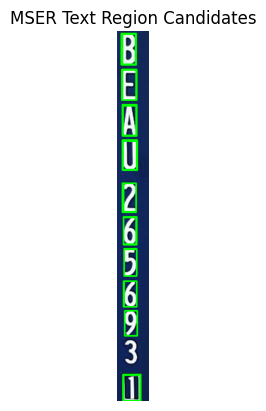

✅ Text region candidates saved as 'mser_text_regions.png'


In [3]:
import cv2
import numpy as np

# Load image
image = cv2.imread(r'cropped_images\124126001_0.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create MSER detector (without arguments)
mser = cv2.MSER_create()

# Set parameters
mser.setMinArea(550)
mser.setMaxArea(1100)

# Detect regions
regions, _ = mser.detectRegions(gray)

# Draw convex hulls
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

# Draw bounding boxes
vis = image.copy()
for hull in hulls:
    x, y, w, h = cv2.boundingRect(hull)
    if w > 10 and h > 10 and h/w < 5:  # Optional filters
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
# Visualize results
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("MSER Text Region Candidates")
plt.axis('off')
plt.show()
# Save the visualization
cv2.imwrite("mser_text_regions.png", vis)
print("✅ Text region candidates saved as 'mser_text_regions.png'")


Mean value of the binary image: 82.13752289699873


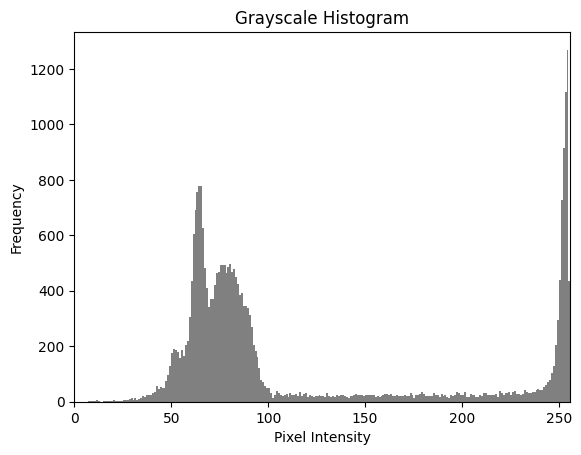

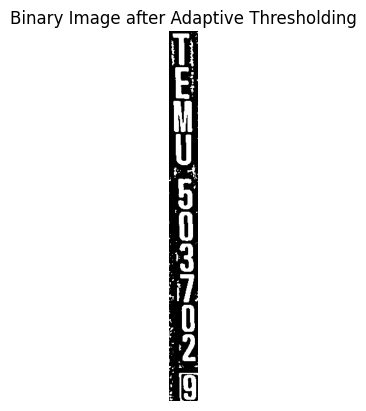

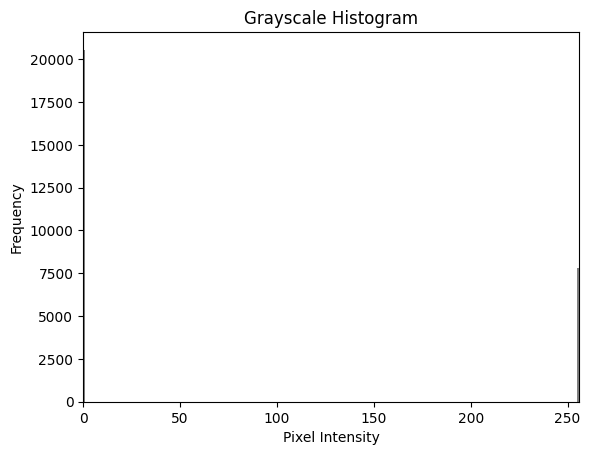

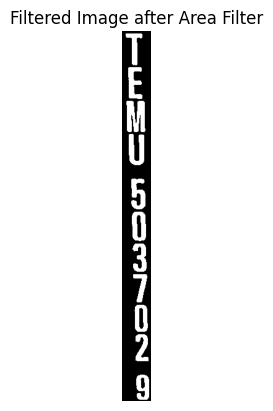

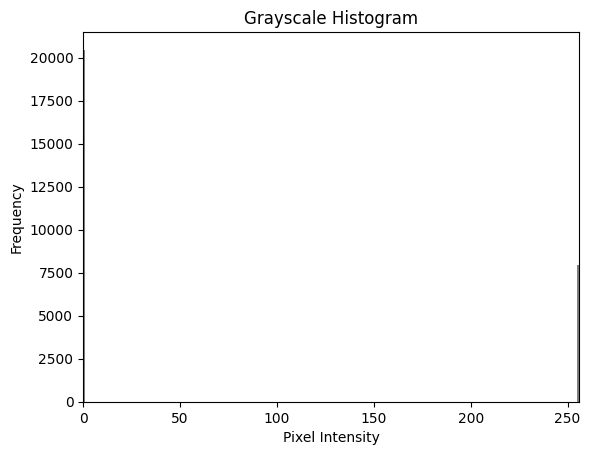

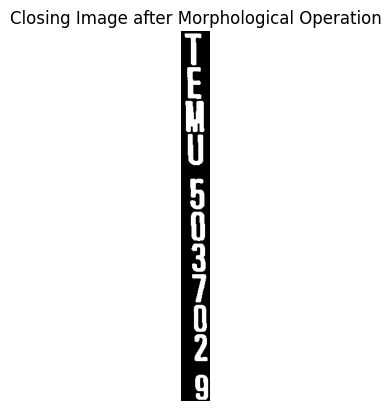

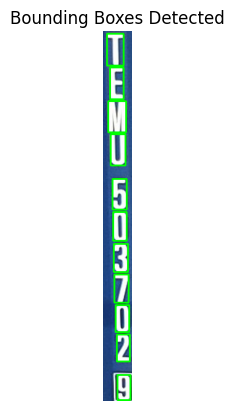

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

inputImage = cv2.imread(r'cropped_images\152733001_0.jpg')
inputCopy = inputImage.copy()

# Convert BGR to grayscale:
grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)

# Set the adaptive thresholding (gaussian) parameters:
windowSize = 31
windowConstant = -1
# Apply the threshold:
binaryImage = cv2.adaptiveThreshold(grayscaleImage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, windowSize, windowConstant)

# Condition on mean value of the binary image:
# If the mean value is less than 0.5, invert the binary image:
mean_val = np.mean(binaryImage)
if mean_val > 100:  # Adjusted threshold for binary image
    binaryImage = cv2.bitwise_not(binaryImage)
print(f"Mean value of the binary image: {mean_val}")

# Visualize the grayscale histogram:
plt.hist(grayscaleImage.ravel(), bins=256, range=[0, 256], color='gray')
plt.title("Grayscale Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.xlim([0, 256])
plt.show()

# Visualize the binary image:
plt.imshow(binaryImage, cmap='gray')
plt.title("Binary Image after Adaptive Thresholding")
plt.axis('off')
plt.show()

# Perform an area filter on the binary blobs:
componentsNumber, labeledImage, componentStats, componentCentroids = \
cv2.connectedComponentsWithStats(binaryImage, connectivity=4)

# Set the minimum pixels for the area filter:
minArea = 250

# Get the indices/labels of the remaining components based on the area stat
# (skip the background component at index 0)
remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]

# Filter the labeled pixels based on the remaining labels,
# assign pixel intensity to 255 (uint8) for the remaining pixels
filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8')

# Visualize the grayscale histogram:
plt.hist(filteredImage.ravel(), bins=256, range=[0, 256], color='gray')
plt.title("Grayscale Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.xlim([0, 256])
plt.show()

# Visualize the filtered image:
plt.imshow(filteredImage, cmap='gray')
plt.title("Filtered Image after Area Filter")
plt.axis('off')
plt.show()

# Set kernel (structuring element) size:
kernelSize = 3

# Set operation iterations:
opIterations = 1

# Get the structuring element:
maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))

# Perform closing:
closingImage = cv2.morphologyEx(filteredImage, cv2.MORPH_CLOSE, maxKernel, None, None, opIterations, cv2.BORDER_REFLECT101)

# Visualize the grayscale histogram:
plt.hist(closingImage.ravel(), bins=256, range=[0, 256], color='gray')
plt.title("Grayscale Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.xlim([0, 256])
plt.show()

# Visualize the closing image:
plt.imshow(closingImage, cmap='gray')
plt.title("Closing Image after Morphological Operation")
plt.axis('off')
plt.show()

# Get each bounding box
# Find the big contours/blobs on the filtered image:
contours, hierarchy = cv2.findContours(closingImage, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

contours_poly = [None] * len(contours)
# The Bounding Rectangles will be stored here:
boundRect = []

# Alright, just look for the outer bounding boxes:
for i, c in enumerate(contours):

    if hierarchy[0][i][3] == -1:
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect.append(cv2.boundingRect(contours_poly[i]))


# Draw the bounding boxes on the (copied) input image:
for i in range(len(boundRect)):
    # Condition to filter out small bounding boxes
    if boundRect[i][2] < 10 or boundRect[i][3] < 10:
        continue
    color = (0, 255, 0)
    cv2.rectangle(inputCopy, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0] + boundRect[i][2]), int(boundRect[i][1] + boundRect[i][3])), color, 2)

# Visualize the bounding boxes
plt.imshow(cv2.cvtColor(inputCopy, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes Detected")
plt.axis('off')
plt.show()

Mean value of the binary image: 82.09663146717008


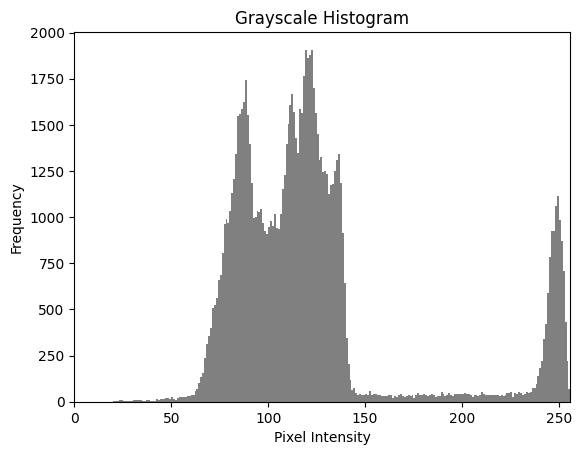

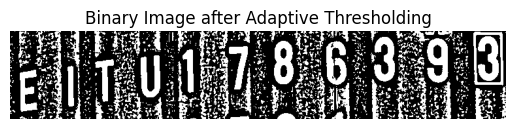

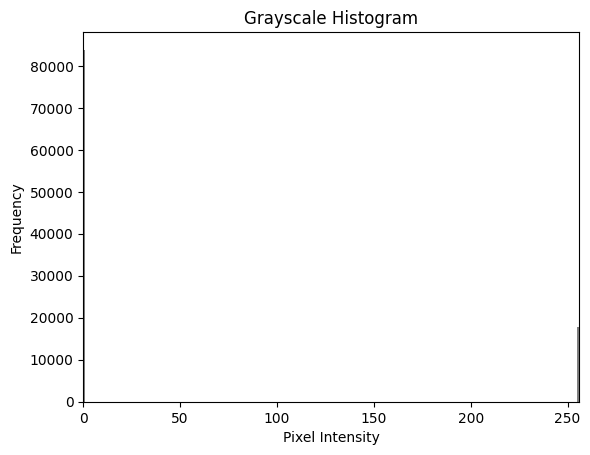

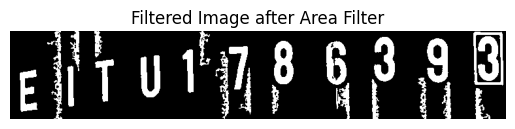

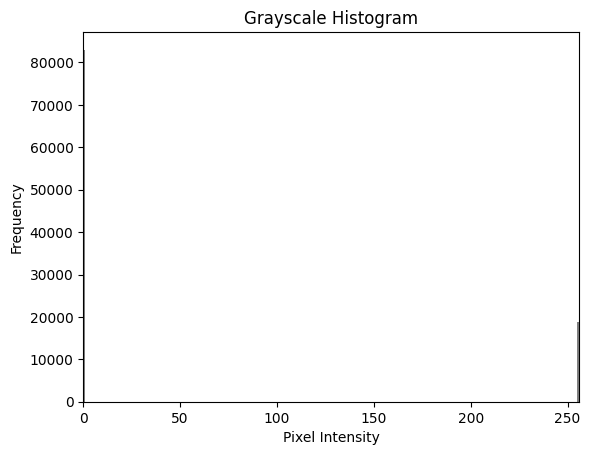

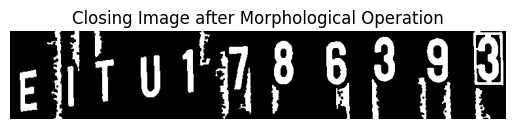


image 1/1 c:\Users\perso\Desktop\Stage\ContainerVision-Marsa_Maroc\notebook\cropped_images\1-122720001-OCR-RF-D01.jpg_0.jpg: 128x640 12 0s, 57.0ms
Speed: 1.2ms preprocess, 57.0ms inference, 2.1ms postprocess per image at shape (1, 3, 128, 640)


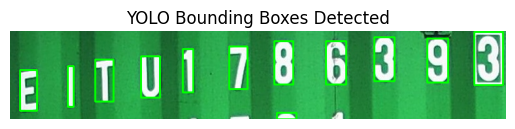

In [ ]:
def adaptive_threshold_and_filter(image_path, min_area=250, window_size=31, window_constant=-1, kernel_size=3, op_iterations=1):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    inputImage = cv2.imread(image_path)
    inputCopy = inputImage.copy()

    # Convert BGR to grayscale:
    grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)

    # Set the adaptive thresholding (gaussian) parameters:
    # Apply the threshold:
    binaryImage = cv2.adaptiveThreshold(
        grayscaleImage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, window_size, window_constant
    )

    # Invert if mean value is high (background is white)
    mean_val = np.mean(binaryImage)
    if mean_val > 100:
        binaryImage = cv2.bitwise_not(binaryImage)
    print(f"Mean value of the binary image: {mean_val}")

    # Visualize the grayscale histogram:
    plt.hist(grayscaleImage.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.show()

    # Visualize the binary image:
    plt.imshow(binaryImage, cmap='gray')
    plt.title("Binary Image after Adaptive Thresholding")
    plt.axis('off')
    plt.show()

    # Perform an area filter on the binary blobs:
    componentsNumber, labeledImage, componentStats, componentCentroids = \
        cv2.connectedComponentsWithStats(binaryImage, connectivity=4)

    # Get the indices/labels of the remaining components based on the area stat
    remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= min_area]

    # Filter the labeled pixels based on the remaining labels
    filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels), 255, 0).astype('uint8')

    # Visualize the grayscale histogram:
    plt.hist(filteredImage.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.show()

    # Visualize the filtered image:
    plt.imshow(filteredImage, cmap='gray')
    plt.title("Filtered Image after Area Filter")
    plt.axis('off')
    plt.show()

    # Morphological closing:
    maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    closingImage = cv2.morphologyEx(filteredImage, cv2.MORPH_CLOSE, maxKernel, None, None, op_iterations, cv2.BORDER_REFLECT101)

    # Visualize the grayscale histogram:
    plt.hist(closingImage.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.show()

    # Visualize the closing image:
    plt.imshow(closingImage, cmap='gray')
    plt.title("Closing Image after Morphological Operation")
    plt.axis('off')
    plt.show()

    # Get each bounding box
    contours, hierarchy = cv2.findContours(closingImage, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours_poly = [None] * len(contours)
    boundRect = []

    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

    # Draw the bounding boxes on the (copied) input image:
    for i in range(len(boundRect)):
        if boundRect[i][2] < 10 or boundRect[i][3] < 10:
            continue
        color = (0, 255, 0)
        cv2.rectangle(inputCopy, (int(boundRect[i][0]), int(boundRect[i][1])),
                      (int(boundRect[i][0] + boundRect[i][2]), int(boundRect[i][1] + boundRect[i][3])), color, 2)

    # Visualize the bounding boxes
    plt.imshow(cv2.cvtColor(inputCopy, cv2.COLOR_BGR2RGB))
    plt.title("Bounding Boxes Detected")
    plt.axis('off')
    plt.show()

    return closingImage, boundRect

closingImage, boundRect = adaptive_threshold_and_filter(r'cropped_images\152733001_0.jpg')

Mean value of the binary image: 70.21593594119192


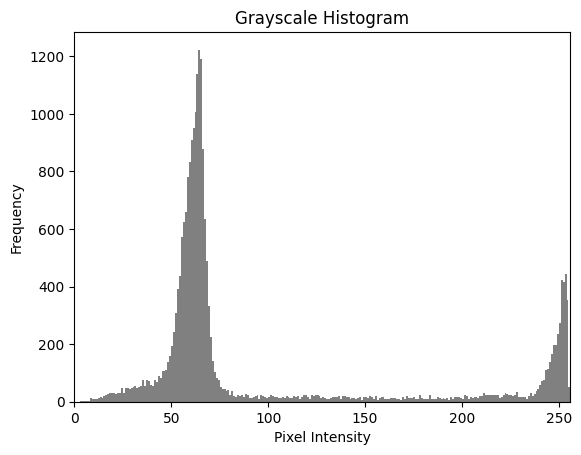

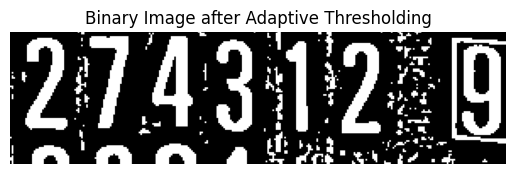

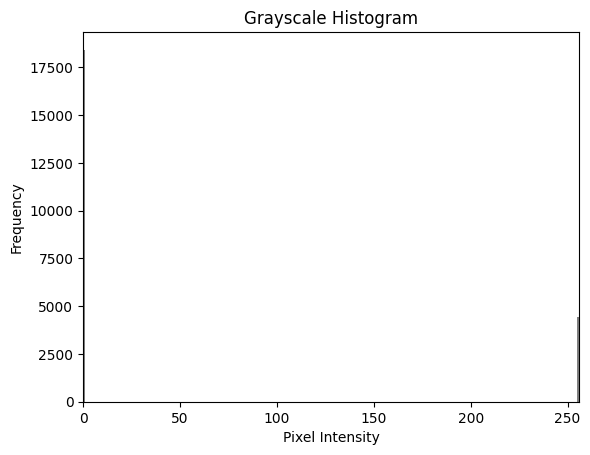

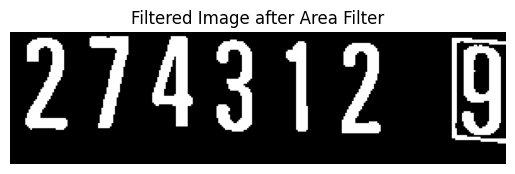

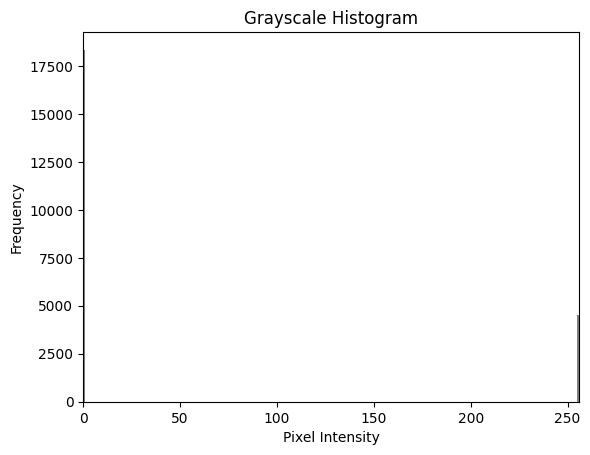

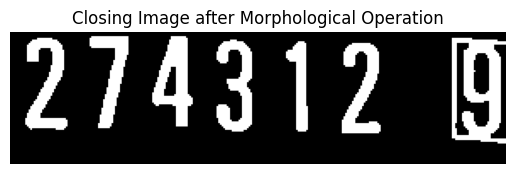


image 1/1 c:\Users\perso\Desktop\Stage\ContainerVision-Marsa_Maroc\notebook\labeled_samples\130713001\1-130713001-OCR-RF-D01\1-130713001-OCR-RF-D01_crop_1_class-1.jpg: 192x640 11 0s, 49.3ms
Speed: 2.3ms preprocess, 49.3ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 640)
Filtered out box (12, 67, 23, 11) with height 11 outside of threshold (mean: 41.2, std: 19.584687896415407)
Filtered out box (85, 66, 25, 12) with height 12 outside of threshold (mean: 41.2, std: 19.584687896415407)
Filtered out box (50, 67, 23, 11) with height 11 outside of threshold (mean: 41.2, std: 19.584687896415407)


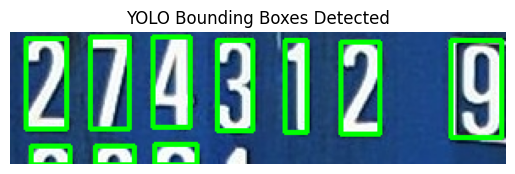

In [26]:
from ultralytics import YOLO

def adaptive_threshold_and_filter(image_path, min_area=250, window_size=31, window_constant=-1, kernel_size=3, op_iterations=1):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    inputImage = cv2.imread(image_path)
    inputCopy = inputImage.copy()

    # Convert BGR to grayscale:
    grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)

    # Set the adaptive thresholding (gaussian) parameters:
    # Apply the threshold:
    binaryImage = cv2.adaptiveThreshold(
        grayscaleImage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, window_size, window_constant
    )

    # Invert if mean value is high (background is white)
    mean_val = np.mean(binaryImage)
    if mean_val > 100:
        binaryImage = cv2.bitwise_not(binaryImage)
    print(f"Mean value of the binary image: {mean_val}")

    # Visualize the grayscale histogram:
    plt.hist(grayscaleImage.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.show()

    # Visualize the binary image:
    plt.imshow(binaryImage, cmap='gray')
    plt.title("Binary Image after Adaptive Thresholding")
    plt.axis('off')
    plt.show()

    # Perform an area filter on the binary blobs:
    componentsNumber, labeledImage, componentStats, componentCentroids = \
        cv2.connectedComponentsWithStats(binaryImage, connectivity=4)

    # Get the indices/labels of the remaining components based on the area stat
    remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= min_area]

    # Filter the labeled pixels based on the remaining labels
    filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels), 255, 0).astype('uint8')

    # Visualize the grayscale histogram:
    plt.hist(filteredImage.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.show()

    # Visualize the filtered image:
    plt.imshow(filteredImage, cmap='gray')
    plt.title("Filtered Image after Area Filter")
    plt.axis('off')
    plt.show()

    # Morphological closing:
    maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    closingImage = cv2.morphologyEx(filteredImage, cv2.MORPH_CLOSE, maxKernel, None, None, op_iterations, cv2.BORDER_REFLECT101)

    # Visualize the grayscale histogram:
    plt.hist(closingImage.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.xlim([0, 256])
    plt.show()

    # Visualize the closing image:
    plt.imshow(closingImage, cmap='gray')
    plt.title("Closing Image after Morphological Operation")
    plt.axis('off')
    plt.show()


    # Load YOLO model (update the path if needed)
    model = YOLO('../runs/detect/train2/weights/best.pt')

    # Run YOLO detection
    results = model(image_path)  # image_path should be defined earlier

    boundRect = []
    inputCopy = cv2.imread(image_path)
    inputCopy = cv2.cvtColor(inputCopy, cv2.COLOR_BGR2RGB)

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        confs = result.boxes.conf.cpu().numpy()
        for box, conf in zip(boxes, confs):
            if conf >= 0.75:
                x1, y1, x2, y2 = map(int, box[:4])
                w = x2 - x1
                h = y2 - y1
                boundRect.append((x1, y1, w, h))
                color = (0, 255, 0)
                cv2.rectangle(inputCopy, (x1, y1), (x2, y2), color, 2)
    
    # After you get boundRect and inputImage is loaded

    # Convert to numpy array for easier processing
    boundRect_np = np.array(boundRect)
    if len(boundRect_np) > 0:
        widths = boundRect_np[:, 2]
        heights = boundRect_np[:, 3]

        mean_w = np.mean(widths)
        mean_h = np.mean(heights)
        std_w = np.std(widths)
        std_h = np.std(heights)

        # Keep only boxes within a threshold (e.g., 1 std) of the mean width and height
        keep = []
        for box in boundRect:
            w, h = box[2], box[3]
            if (abs(h - mean_h) <= std_h):
                keep.append(box)
            else :
                print(f"Filtered out box {box} with height {h} outside of threshold (mean: {mean_h}, std: {std_h})")
        boundRect = keep
    
    h, w = inputImage.shape[:2]
    if w > h:
        # Horizontal: sort by x (left to right)
        boundRect = sorted(boundRect, key=lambda b: b[0])
    else:
        # Vertical: sort by y (top to bottom)
        boundRect = sorted(boundRect, key=lambda b: b[1])

    # Visualize the bounding boxes
    plt.imshow(inputCopy)
    plt.title("YOLO Bounding Boxes Detected")
    plt.axis('off')
    plt.show()

    return closingImage, boundRect  # closingImage is not relevant here, so return None

closingImage, boundRect = adaptive_threshold_and_filter(r'labeled_samples\130713001\1-130713001-OCR-RF-D01\1-130713001-OCR-RF-D01_crop_1_class-1.jpg')

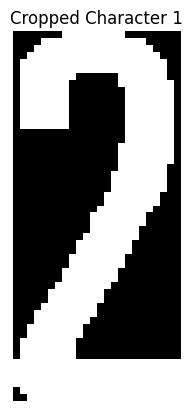

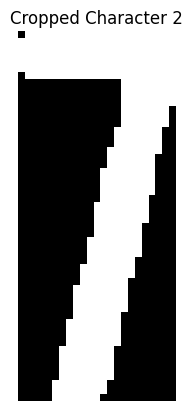

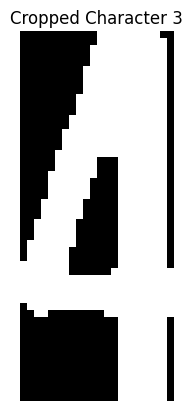

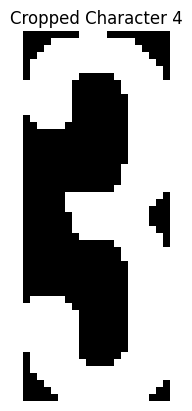

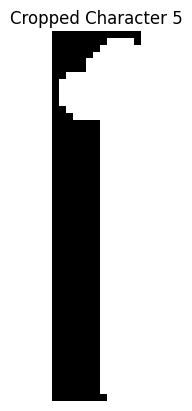

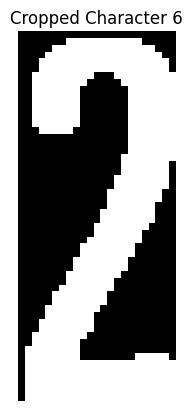

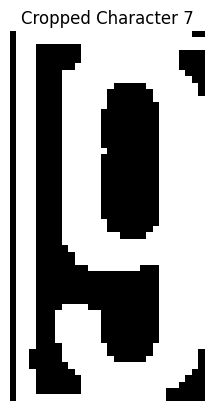

In [27]:
import matplotlib.pyplot as plt

# Crop the characters:
for i in range(len(boundRect)):
    # Get the roi for each bounding rectangle:
    x, y, w, h = boundRect[i]

    # Crop the roi:
    croppedImg = closingImage[y:y + h, x:x + w]
    # Visualize the cropped image
    plt.imshow(croppedImg, cmap='gray')
    plt.title(f"Cropped Character {i+1}")
    plt.axis('off')
    plt.show()

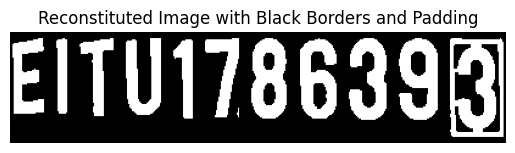

True

In [19]:
import cv2
import numpy as np

# Suppose cropped_images is a list of your cropped character images (all grayscale)
cropped_images = []
for i in range(len(boundRect)):
    x, y, w, h = boundRect[i]
    croppedImg = closingImage[y:y + h, x:x + w]
    cropped_images.append(croppedImg)

# Set the black space width (in pixels)
space = 10

# Find the maximum height among all cropped images
max_height = max(img.shape[0] for img in cropped_images)

# Resize all images to the same height (pad with black if needed)
cropped_images_padded = []
for img in cropped_images:
    h, w = img.shape
    if h < max_height:
        pad = np.zeros((max_height - h, w), dtype=img.dtype)
        img_padded = np.vstack([img, pad])
    else:
        img_padded = img
    cropped_images_padded.append(img_padded)

# Create black space image
black_space = np.zeros((max_height, space), dtype=np.uint8)

# Concatenate images with black space in between
result = cropped_images_padded[0]
for img in cropped_images_padded[1:]:
    result = np.hstack([result, black_space, img])

# Add black space at the top and bottom
top_pad = 5   # pixels to add at the top
bottom_pad = 5  # pixels to add at the bottom

result_padded = np.pad(
    result,
    pad_width=((top_pad, bottom_pad), (2, 2)),  # (top, bottom), (left, right)
    mode='constant',
    constant_values=0
)

# Show the result
import matplotlib.pyplot as plt
plt.imshow(result_padded, cmap='gray')
plt.axis('off')
plt.title('Reconstituted Image with Black Borders and Padding')
plt.show()

# Save the reconstituted image with borders and padding
cv2.imwrite("reconstituted_image.png", result)

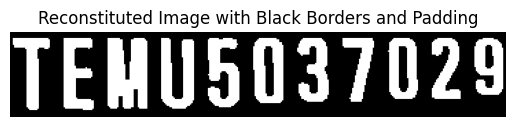

Reconstituted image saved as 'reconstituted_image.png'


In [106]:
def reconstitute_characters_with_padding(closingImage, boundRect, space=10, top_pad=5, bottom_pad=5, left_pad=2, right_pad=2, save_path="reconstituted_image.png"):
    """
    Crops character images from bounding rectangles, pads and concatenates them with black borders.
    Returns the final padded image.
    """
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    # Crop character images (reverse order as in your code)
    cropped_images = []
    for i in range(len(boundRect)-1, -1, -1):
        x, y, w, h = boundRect[i]
        croppedImg = closingImage[y:y + h, x:x + w]
        cropped_images.append(croppedImg)

    # Find the maximum height among all cropped images
    max_height = max(img.shape[0] for img in cropped_images)

    # Resize all images to the same height (pad with black if needed)
    cropped_images_padded = []
    for img in cropped_images:
        h, w = img.shape
        if h < max_height:
            pad = np.zeros((max_height - h, w), dtype=img.dtype)
            img_padded = np.vstack([img, pad])
        else:
            img_padded = img
        cropped_images_padded.append(img_padded)

    # Create black space image
    black_space = np.zeros((max_height, space), dtype=np.uint8)

    # Concatenate images with black space in between
    result = cropped_images_padded[0]
    for img in cropped_images_padded[1:]:
        result = np.hstack([result, black_space, img])

    # Add black space at the top, bottom, left, and right
    result_padded = np.pad(
        result,
        pad_width=((top_pad, bottom_pad), (left_pad, right_pad)),
        mode='constant',
        constant_values=0
    )

    # Show the result
    plt.imshow(result_padded, cmap='gray')
    plt.axis('off')
    plt.title('Reconstituted Image with Black Borders and Padding')
    plt.show()

    # Save the reconstituted image with borders and padding
    cv2.imwrite(save_path, result_padded)
    print(f"Reconstituted image saved as '{save_path}'")

    return result_padded

# Example usage:
reconstituted_img = reconstitute_characters_with_padding(closingImage, boundRect, space=10, top_pad=5, bottom_pad=5, left_pad=2, right_pad=2, save_path="reconstituted_image.png")

In [109]:
!yolo task=detect mode=predict model=runs/detect/train2/weights/best.pt source=cropped_images

'yolo' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


# Detection of sealed container (using basic morphology operation)

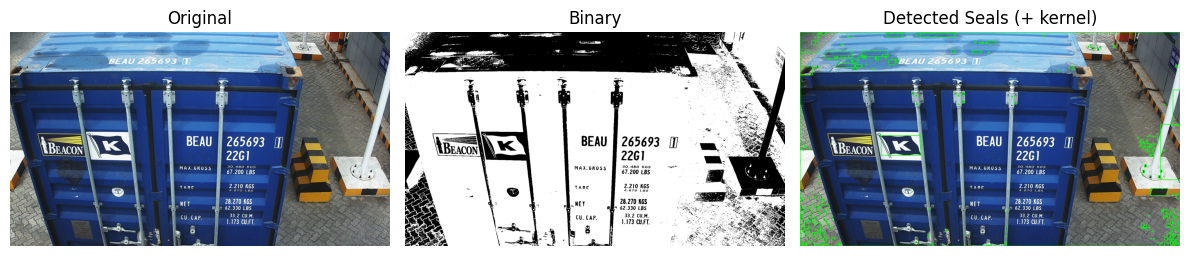

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image (update the path as needed)
image = cv2.imread('organised_samples/124126001/1-124126001-OCR-AH-A01.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold to get binary image (adjust threshold as needed)
_, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)

# Create a structuring element in the shape of a plus sign (+)
plus_kernel = np.zeros((5, 5), dtype=np.uint8)
plus_kernel[4, :] = 1  # horizontal line
plus_kernel[:, 2] = 1  # vertical line

# Apply morphological operation (e.g., hit-or-miss or opening/closing)
morph = cv2.morphologyEx(binary, cv2.MORPH_OPEN, plus_kernel)

# Optional: Find contours of detected seal-like regions
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = image.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Binary')
plt.imshow(binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Detected Seals (+ kernel)')
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# Detection sealed using yolo finetuned model

# OCR model from scratch using CNN model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Dataset
class CharDataset(Dataset):
    def __init__(self, folder):
        self.data = []
        self.labels = []
        self.classes = sorted(list(set([f.split("_")[0] for f in os.listdir(folder)])))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.folder = folder
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ])
        for fname in os.listdir(folder):
            label = fname.split("_")[0]
            self.data.append(fname)
            self.labels.append(self.class_to_idx[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.data[idx])
        image = self.transform(Image.open(img_path))
        label = self.labels[idx]
        return image, label

# Model
class CharCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Training
dataset = CharDataset("augmented_characters")
loader = DataLoader(dataset, batch_size=32, shuffle=True)
model = CharCNN(num_classes=len(dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for x, y in loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: loss = {total_loss:.4f}")
    
# Save the model
torch.save(model.state_dict(), "char_cnn.pth")

# Load the model for inference
def load_model(model_path, num_classes):
    model = CharCNN(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_characters(model, image_paths, transform):
    model.eval()
    predictions = []
    text = ""
    with torch.no_grad():
        for img_path in image_paths:
            image = transform(Image.open(img_path)).unsqueeze(0)  # Add batch dimension
            output = model(image)
            pred = output.argmax(dim=1).item()
            predictions.append(pred)
            
            text = text + CharDataset('augmented_characters').classes[pred]
    return text, predictions

# Example usage
if __name__ == "__main__":
    model = load_model("char_cnn.pth", num_classes=len(CharDataset("augmented_characters").classes))
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])
    
    # Replace with your image paths
    test_image_paths = ["cropped_characters\G_labeled_1-132130001-OCR-LF-C01.jpg_-1.jpg", "cropped_characters\7_labeled_1-143242001-OCR-LB-C02.jpg_0.jpg"]
    predictions = predict_characters(model, test_image_paths, transform)
    
    for img_path, pred in zip(test_image_paths, predictions):
        print(f"Image: {img_path}, Predicted Class: {CharDataset('augmented_characters').classes[pred]}")

Epoch 0: loss = 220.2191
Epoch 1: loss = 45.3774
Epoch 2: loss = 22.3650
Epoch 3: loss = 12.8528
Epoch 4: loss = 8.5854
Epoch 5: loss = 5.8826
Epoch 6: loss = 3.9065
Epoch 7: loss = 5.4916
Epoch 8: loss = 2.4757
Epoch 9: loss = 4.4838


OSError: [Errno 22] Invalid argument: 'cropped_characters\x07_labeled_1-143242001-OCR-LB-C02.jpg_0.jpg'

In [8]:
model = load_model("char_cnn.pth", num_classes=len(CharDataset("augmented_characters").classes))
print('classes:', len(CharDataset("augmented_characters").classes))
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

print("Model classes:", CharDataset("augmented_characters").classes)

# Replace with your image paths
test_image_paths = ["cropped_characters/G_labeled_1-132130001-OCR-LF-C01.jpg_-1.jpg", "cropped_characters/7_labeled_1-143242001-OCR-LB-C02.jpg_0.jpg"]
predictions = predict_characters(model, test_image_paths, transform)

for img_path, pred in zip(test_image_paths, predictions):
    print(f"Image: {img_path}, Predicted Class: {CharDataset('augmented_characters').classes[pred]}")

classes: 31
Model classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'W', 'X', 'Y']
Image: cropped_characters/G_labeled_1-132130001-OCR-LF-C01.jpg_-1.jpg, Predicted Class: G
Image: cropped_characters/7_labeled_1-143242001-OCR-LB-C02.jpg_0.jpg, Predicted Class: 7
